In [2]:
import argparse
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from synthetic_datasets import SineSyntheticDataset

from criterions import QuantileLoss
from configuration import get_attention_hparam_grid, make_attn_module_class, get_attention_names
from sine_experiment import train, val_step, inference

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

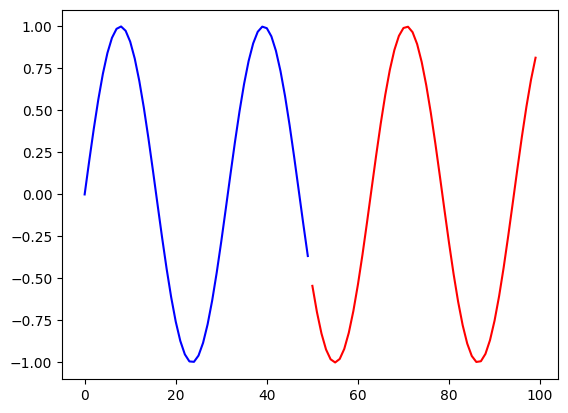

In [4]:
dataset = SineSyntheticDataset(
    len_timeseries=5000,
    seq_len=50,
    shift=50,
    alpha=0.2
)

src_x, src_y, tgt_x, tgt_y = dataset[0]

plt.plot(src_x.numpy(), src_y.numpy(), 'b')
plt.plot(tgt_x.numpy(), tgt_y.numpy(), 'r')

src_x.shape, src_y.shape, tgt_x.shape, tgt_y.shape

In [5]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(3920, 490, 490, 122, 7, 7)

In [6]:
attn_names = get_attention_names()

config = argparse.Namespace()
config.quantiles = [0.1, 0.5, 0.9]
config.lr = 1e-2
config.epochs = 200
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.patience = 10
config.attn_dropout = 0.1

config.emb_size = 20
config.n_heads = 4
config.n_hidden = 32
config.ffn_n_hidden = 10

results = {}

for attn_name in attn_names[:1]:
    
    attn_hparam_grid = get_attention_hparam_grid(attn_name)
    attn_module_class = make_attn_module_class(attn_name)
    
    best_model = None
    best_val_loss = float('inf')
    best_attn_hparams = None
    best_train_history, best_val_history = None, None
    
    print(f'Starting training for attention module: {attn_name}')
    
    for attn_hparams in attn_hparam_grid:
        
        attn_hparams['dropout_rate'] = config.attn_dropout
        if attn_name == 'imp':
            attn_hparams['input_size'] = config.n_hidden // config.n_heads
        
        attn_module = attn_module_class(**attn_hparams)
        model, train_history, val_history, val_loss = train(attn_module, config, train_dl, val_dl, dataset.mask, verbose=False)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_attn_hparams = attn_hparams
            best_train_history = train_history
            best_val_history = val_history
            
        print(f'\t{attn_hparams=}, {val_loss=:.4f}, {best_val_loss=:.4f}')
    
    criterion = QuantileLoss(config).to(config.device)
    test_loss = val_step(best_model, criterion, test_dl, dataset.mask, config.device).cpu()    
    results[attn_name] = {
        'attn_name': attn_name, 
        'test_loss': test_loss, 
        'best_model': best_model, 
        'best_attn_params': best_attn_hparams,
        'best_train_history': best_train_history, 
        'best_val_history': best_val_history
    }

Starting training for attention module: sdp
	attn_hparams={'dropout_rate': 0.1}, val_loss=0.1448, best_val_loss=0.1448


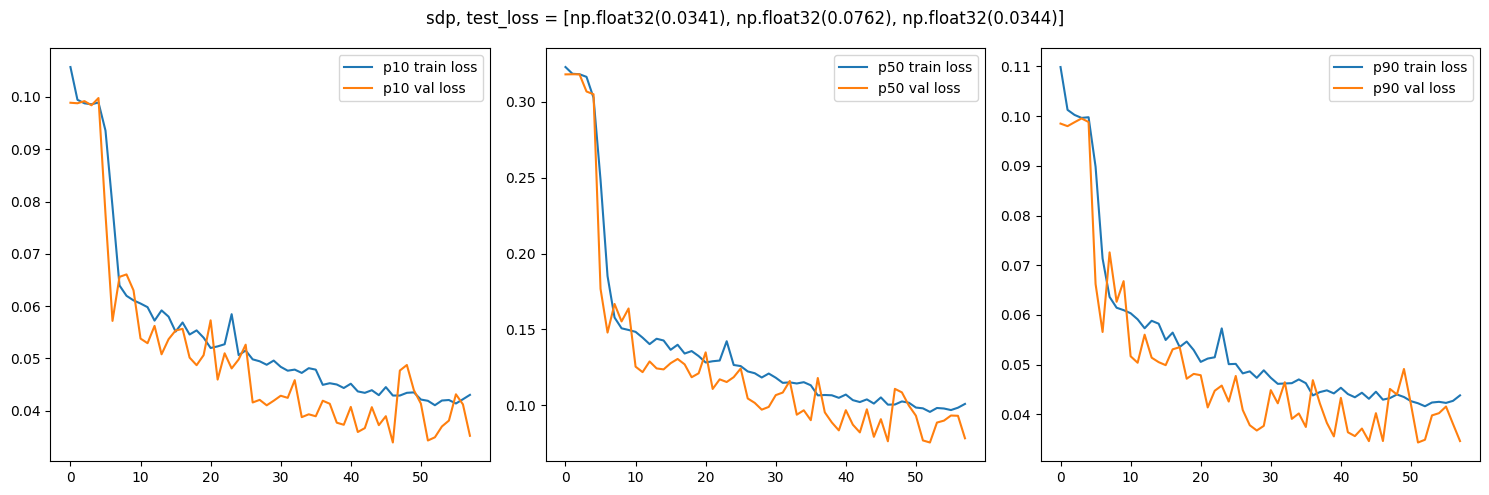

In [7]:
for name, exp in results.items():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
    
    train_history = exp['best_train_history']
    val_history = exp['best_val_history']
    
    p10_train = [x['p10'] for x in train_history]
    p50_train = [x['p50'] for x in train_history]
    p90_train = [x['p90'] for x in train_history]
    
    p10_val = [x['p10'] for x in val_history]
    p50_val = [x['p50'] for x in val_history]
    p90_val = [x['p90'] for x in val_history]
    
    ax1.plot(p10_train, label='p10 train loss')
    ax1.plot(p10_val, label='p10 val loss')
    ax1.legend()
    
    ax2.plot(p50_train, label='p50 train loss')
    ax2.plot(p50_val, label='p50 val loss')
    ax2.legend()
    
    ax3.plot(p90_train, label='p90 train loss')
    ax3.plot(p90_val, label='p90 val loss')
    ax3.legend()
    
    fig.suptitle(f'{exp["attn_name"]}, test_loss = {[round(q, 4) for q in exp["test_loss"].numpy()]}')
    
    plt.tight_layout()
    plt.show()

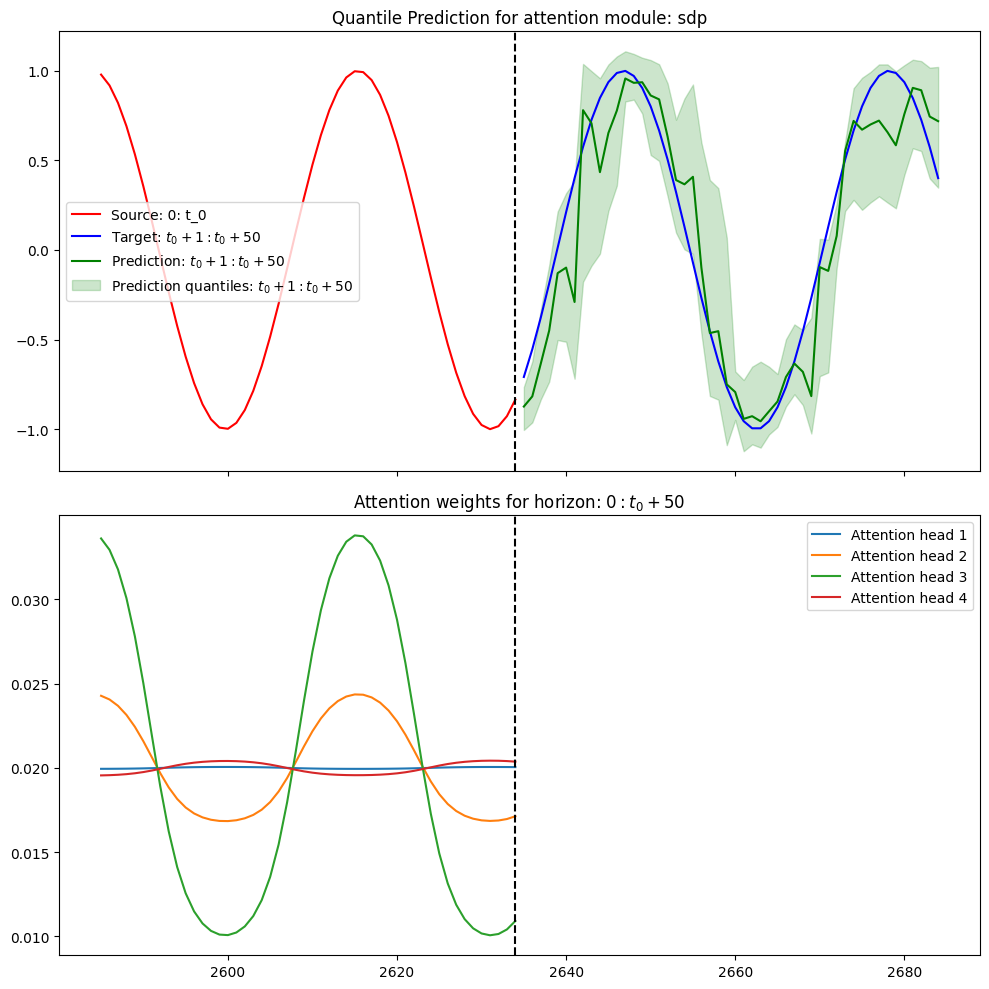

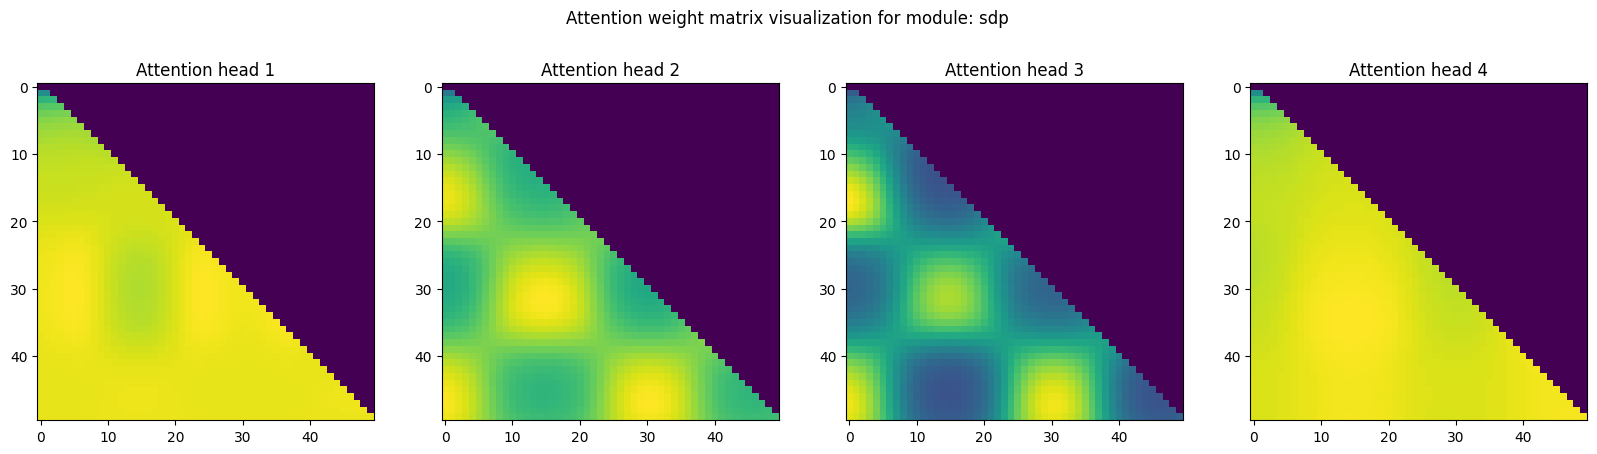

In [8]:
idx = 15

for name, exp in results.items():
    
    best_model = exp['best_model']
    attn_name = exp['attn_name']
    
    inference(idx, best_model, test_set, config, dataset.mask, attn_name)

In [204]:
results_path = os.path.join('results_sine_exp')

os.makedirs(results_path, exist_ok=True)

In [206]:
for name, exp in results.items():
    ckpt = {
        'name': name, 
        'config': config, 
        'model': exp['best_model'].state_dict(), 
        'attn_name': exp['attn_name'], 
        'test_loss': exp['test_loss'], 
        'best_model': exp['best_model'], 
        'best_attn_params': exp['best_attn_params']
    }
    
    torch.save(ckpt, os.path.join(results_path, f'{name}_checkpoint.pt'))